# Without sWeights: `common_B0TODst3pi_Dst_constr_BDT-1.25u{1,2};{i}`

# Fit the complete data
WITH A LOOP IMPLEMENTED
This file is fitting for different cuts on the BDT variable

In the `fit_common_uncertainties.ipynb`, the fixed parameters of the (1) $D^*\pi\pi\pi$ and (2) $D^*K\pi\pi$  distributions have been changed within their uncertainty intervals, according to a gaussian. $n_sig$ have been computed for each of this variation.

The goal of this documend is 
- plotting the two $n_{sig}$ distributions.
    - **Mode 1**: $n_{sig}$ distribution by varying the tail parameters of $D^*\pi\pi\pi$
    - **Mode 2**: $n_{sig}$ distribution by varying all the parameters of $D^*K\pi\pi$ 
    - **Mode 2**: $n_{sig}$ distribution by varying all the parameters of $D^*D_s$ 
- plotting the changed parameters in these 2 modes
- computed the systematic uncertainty, which is the quadratic sum of the standard deviation of the $n_{sig}$ distributionobtained with the 2 modes

In [1]:
data_name_common = 'common_B0TODst3pi_Dst_constr'
data_name_B0toDstDs_common = 'common_B0TODstDs_Dst_constr'

BDT = -1.25

data_name_MC = 'MC_constr_opposedCB_sharedMean'
data_name_KPiPi = "data_KPiPi_constr"

data_name = f'{data_name_common}_BDT{BDT}'
data_name_B0toDstDs = f'{data_name_B0toDstDs_common}_BDT{BDT}'

## Import

In [2]:
from uncertainties import unumpy as unp
from uncertainties import ufloat
import zfit

from math import sqrt
import numpy as np

from bd2dst3pi.locations import loc

import sys
sys.path.append(loc.ROOT + '/library')

from HEA.fit import retrieve_params, get_params_without_BDT
from HEA.plot.tools import save_fig
from HEA.plot import plot_hist_var
from HEA.plot.fit import plot_hist_fit_var
from HEA.fit.fit import define_zparams, sum_crystalball_or_gaussian

## Names of the datasets

## Load data

### Name of the parameters

In [3]:
latex_params_KPiPi = {
    'alphaL_Kpipi'           : '$\\alpha_{L, D^* K\\pi\\pi}$',
    'alphaR_Kpipi'           : '$\\alpha_{R, D^* K\\pi\\pi}$',
    'nL_Kpipi'               : '$n_{L, D^* K\\pi\\pi}$',
    'nR_Kpipi'               : '$n_{R, D^* K\\pi\\pi}$',
    'fraction_Kpipi'         : '$f_{\\frac{L}{R},D^* K\\pi\\pi}$',
    'muL_Kpipi'              : '$\\mu_{L, D^* K\\pi\\pi}$',
    'sigmaL_Kpipi'           : '$\\sigma_{L, D^* K\\pi\\pi}$',
    'muR_Kpipi'              : '$\\mu_{R, D^* K\\pi\\pi}$',
    'sigmaR_Kpipi'           : '$\\sigma_{R, D^* K\\pi\\pi}$',
}

latex_params = {
    # Signal
    'mu'      : '$\\mu_S$',
    'sigmaL'  : '$\\sigma_{L,S}$',
    'sigmaR'  : '$\\sigma_{R,S}$',    
    'alphaL'  : '$\\alpha_{L,S}$',
    'alphaR'  : '$\\alpha_{R,S}$',
    'nL'      : '$n_{L,S}$',
    'nR'      : '$n_{R,S}$',
    'fraction': '$f_{\\frac{L}{R},S}$',
    'n_sig'   : '$n_{B^0 \\to D^* 3\\pi}$',
    'frac': '$f_{\\frac{L}{R},S}$',
    'r_bkgK'  : '$\\frac{n_{B^0 \\to D^*K\\pi\\pi}}{n_{B^0 \\to D^* 3\\pi}}$',
}

latex_params_Ds = {
    # Signal
    f'mu_Ds'      : '$\mu_{D^*D_s}$',
    f'sigma_Ds'   : '$\\sigma_{D^*D_s}$',
    f'n_sig_Ds'   : '$n_{D^*D_s}$',
}

In [4]:
latex_params_dic = {}
latex_params_dic['1'] = latex_params
latex_params_dic['2'] = latex_params_KPiPi
latex_params_dic['2']['r_bkgK'] = latex_params_dic['1']['r_bkgK']
latex_params_dic['3'] = latex_params_Ds


### Start and end indices of mode 1 and mode 2

In [5]:
modes = ['1', '2', '3']

In [6]:
starts = {}
ends = {}
# Mode 1
starts['1'] = 0
ends['1'] = 1539

# Mode 2
starts['2'] = 0
ends['2'] = 1662

# Mode 3
starts['3'] = 0
ends['3'] = 1392

### Statistical uncertainty

In [7]:
n_sig_opt = retrieve_params(f"{data_name}", folder_name=data_name_common)[f'n_sig|BDT{BDT}']
n_sig_opt_err = retrieve_params(f"{data_name}", folder_name=data_name_common)[f'n_sig|BDT{BDT}_err']
print('optimal n_sig =', n_sig_opt)

optimal n_sig = 52321.955341015375


### Nominal values of the parameters that were changed in mode 1 and 2

Create 2 dictionnaries:
- `saved_params`:
    - key: `'Kpipi'`, `'pipipi'` or `'MC'`
    - value: dictionnary of the fitted values
        - key: name of the *optimal* fitted variable. Error if `_err` at the end of the name
        - value: value
- `params_mode`:
    - key: mode, '1' or '2'
    - value: dictionnary
        - key: parameter
        - value: type of data in which the nominal value is saved, 'Kpipi', 'pipipi' or 'MC'

In [8]:
saved_params = {}

## Retrieve the nominal value of the floated parameters in mode 1 and 2 (saved_params) ===========================
# Fixed nR
MC_params = retrieve_params(data_name_MC, folder_name='MC')
saved_params['MC'] = {}
for key, value in MC_params.items():
    saved_params['MC'][key.replace('_MC','')] = value

# fixed B0->DstKPiPi
Kpipi_params = get_params_without_BDT(retrieve_params(data_name_KPiPi, folder_name='data_KPiPi'),
                                     retrieve_err=True) # already in MeV 
saved_params['Kpipi'] = {}
for key, value in Kpipi_params.items():
    if '_err' in key:
        key = key.replace('_err', '') + '_Kpipi' + '_err'
    else:
        key+= '_Kpipi'
    saved_params['Kpipi'][key] = value

# fixed B0->DstDs
Ds_params = get_params_without_BDT(retrieve_params(data_name_B0toDstDs, folder_name=data_name_B0toDstDs_common),
                                     retrieve_err=True) # already in MeV 
saved_params['Ds'] = {}
for key, value in Ds_params.items():
    if key != 'info_fit':
        key = key.replace('_DstDs', '_Ds')
        saved_params['Ds'][key] = value
    
# common with BDT cut (for starting values of the fit)
saved_params['pipipi'] = get_params_without_BDT(retrieve_params(data_name_common, folder_name=data_name_common),
                                               retrieve_err=True)

# key = Parameters that were changed in modes 1 and 2
# value = corresponding PDF ('pipipi' = B0->Dst 3pi and 'Kpipi' = B0-> Dst K pi pi)
params_mode = {}

params_mode['1'] = {'alphaR': 'pipipi', 'nR':'MC', 'alphaL': 'pipipi', 'nL':'pipipi'}

params_mode['2'] = {'r_bkgK': 'pipipi'}
for key in saved_params['Kpipi'].keys():
    if '_err' not in key:
        params_mode['2'][key] = 'Kpipi'

params_mode['3'] = {'mu_Ds': 'Ds', 'sigma_Ds': 'Ds', 'n_sig_Ds': 'Ds'}

        
## Check that I did not forget a parameter in params_mode ========================================
all_params = list(params_mode['1'].keys()) + list(params_mode['2'].keys()) # all the parameters that were changed in mode 1 and 2

# Result of the fit of index 18
result_fit = {}
result_fit['1'] = retrieve_params(f"{data_name}u1;18", folder_name=data_name)
result_fit['2'] = retrieve_params(f"{data_name}u2;18", folder_name=data_name)

for m in '1', '2':
    r_params = result_fit[m]['r_params']
    for param in r_params.keys():
        assert param in all_params, print(list(r_params.keys()), all_params)
        # assert that the floated parameter of one of the fit in mode 1/2 is in all_params 

result_fit['3'] = retrieve_params(f"{data_name}u3;18", folder_name=data_name)
all_params += list(params_mode['3'].keys())
for m in '3':
    r_params = result_fit[m]['r_params']
    for param in r_params.keys():
        assert param in all_params, print(list(r_params.keys()), all_params)
        # assert that the floated parameter of one of the fit in mode 1/2 is in all_params 

In [9]:
saved_params['Ds']

{'lambda_Ds': -9.117706589734098e-15,
 'lambda_Ds_err': 4.1630389780893493e-07,
 'mu2_Ds': 5167.9060601861165,
 'mu2_Ds_err': 3.185638649632322,
 'mu_Ds': 5279.309933849582,
 'mu_Ds_err': 0.5343270732201247,
 'n_bkg2_Ds': 650.4807854398955,
 'n_bkg2_Ds_err': 46.877823139086004,
 'n_bkg_Ds': 53.19558598239224,
 'n_bkg_Ds_err': 83.20729009350175,
 'n_sig_Ds': 1381.332165202385,
 'n_sig_Ds_err': 52.114928774296885,
 'sigma2_Ds': 26.720206885368206,
 'sigma2_Ds_err': 2.2904417336364253,
 'sigma_Ds': 12.452848429314047,
 'sigma_Ds_err': 0.5104525333101287}

### Retrieve the results of the fits which converged

In [10]:
def test_mode(r_params, mode):
    """ Test that I did what I wanted to do during the mode 1 and 2, i.e.
    check that in a result of fit of a given mode, the right parameters have been changed
    and the other parameters are fixed
    
    @r_params   :: result of the fit (saved in the json file)
    @mode       :: '1' or '2', mode associated of the fit
    
    @returns    :: True, if changed the good parameters and fixed the other parameters
    """
    file_ok = True
    for amode in params_mode.keys(): # loop on the modes
        
        # if this is the mode of the fit the corresponding parameters must have changed
        if amode==mode:
            for param, file in params_mode[amode].items():
                if saved_params[file][param]==r_params[param]:
                    print(f'Error in param {param} ; should change')
                    file_ok = False
        # if not, the corresponding variables of the mode must not have changed 
        else:
            for param, file in params_mode[amode].items():
                if param not in saved_params[file]:
                    print(f'{param} not in saved_params[file]')
                    print(saved_params[file])
#                 elif param not in r_params:
#                     print(f'{param} not in r_params')
#                     print(r_params)
                if param in r_params and saved_params[file][param]!=r_params[param]:
                    print(f'Error in param {param} ; should not change')
                    print(f"Saved result: {saved_params[file][param]}")
                    print(f"What it should be: {r_params[param]}")
                    file_ok = False
    return file_ok

In [11]:
# dictionnary of the fitted systematic n_sig for the modes 1 and 2
n_sig_u = {}
for m in modes:
    n_sig_u[m] = []

n_sig = {}
for m in modes:
    n_sig[m] = []

# dictionnary of the parameters that were changed during mode 1 and 2
parameters = {m : {} for m in modes}
for m in modes:
    for param in params_mode[m]:
            parameters[m][param] = []


# list of the fits that are not ok
fit_not_ok = {m : [] for m in modes}


for m in modes:
    print(f'load mode {m}')
    for i in range(starts[m], ends[m]):
        # retrieve the result of the fit of index i
        result_fit = retrieve_params(f"{data_name}u{m};{i}", folder_name=data_name)
        # check that the fit is ok. In this case, add it to the n_sig list
        if result_fit['fit_ok'] and 'True' not in result_fit['info_params']:
            n_sig_u[m].append(ufloat(result_fit[f'n_sig;{i}'], result_fit[f'n_sig;{i}_err']))
            n_sig[m].append(result_fit[f'n_sig;{i}'])
        else:
            print(f'Fit number {i} not ok')
            if 'True' in result_fit['info_params']:
                print("(params at lim)")
                print(result_fit['info_params'])
            fit_not_ok[m].append(i)
        
        if 'r_params' in result_fit:
            test_ok = test_mode(result_fit['r_params'], m)
            if not test_ok:
                print(f'error in {i}')
        else:
            print(f'r_params not in {i}')
            
        for param in params_mode[m]:
            parameters[m][param].append(result_fit['r_params'][param])

for m in modes:
    n_sig[m] = np.array(n_sig[m])

load mode 1
Fit number 20 not ok
Fit number 161 not ok
Fit number 168 not ok
Fit number 250 not ok
Fit number 280 not ok
Fit number 400 not ok
Fit number 515 not ok
Fit number 519 not ok
Fit number 560 not ok
Fit number 567 not ok
Fit number 605 not ok
Fit number 654 not ok
Fit number 657 not ok
Fit number 1523 not ok
load mode 2
Fit number 23 not ok
Fit number 152 not ok
Fit number 157 not ok
Fit number 305 not ok
Fit number 406 not ok
Fit number 443 not ok
Fit number 507 not ok
Fit number 649 not ok
Fit number 720 not ok
Fit number 925 not ok
Fit number 969 not ok
Fit number 1077 not ok
Fit number 1150 not ok
Fit number 1223 not ok
Fit number 1434 not ok
Fit number 1515 not ok
Fit number 1568 not ok
load mode 3
Fit number 0 not ok
Fit number 4 not ok
Fit number 9 not ok
Fit number 20 not ok
Fit number 30 not ok
Fit number 39 not ok
Fit number 44 not ok
Fit number 54 not ok
Fit number 79 not ok
Fit number 107 not ok
Fit number 113 not ok
Fit number 126 not ok
Fit number 137 not ok
Fit

## Distribution of $n_{B^0\to D^*3\pi}$ obtained with mode 1 and mode 2

In [12]:
colors = {}
colors['1'] = 'green'
colors['2'] = 'saddlebrown'
colors['3'] = 'red'

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Figure saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/plots//common_B0TODst3pi_Dst_constr_BDT-1.25/modes


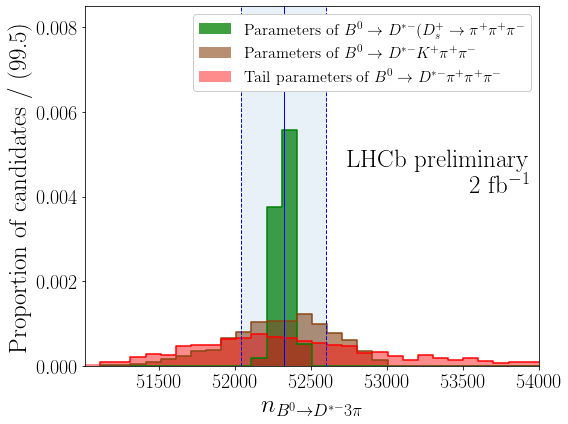

In [13]:
fig, ax = plot_hist_var([unp.nominal_values(n_sig['3']),
                           unp.nominal_values(n_sig['2']),
                           unp.nominal_values(n_sig['1'])], 
                          'signal_yield', 
                          '$n_{B^0 \\to D^{*-}3\\pi}$',
               data_names = ['Parameters of $B^0 \\to D^{*-} (D_s^+ \\to \pi^+\pi^+\pi^-$',
                             'Parameters of $B^0 \\to D^{*-} K^+ \pi^+\pi^-$',
                             'Tail parameters of $B^0 \\to D^{*-} \pi^+\pi^+\pi^-$'
                            ],
              folder_name=data_name, n_bins=30, bar_mode=True, density=True, colors=list(colors.values()),
                         pos_text_LHC=[0.98, 0.6, 'right'], high=54000, save_fig=False, alpha=[0.75, 0.6, 0.45])
ax.axvline(x=n_sig_opt, color='blue', linewidth=1.)
ax.axvspan(n_sig_opt-n_sig_opt_err, n_sig_opt+n_sig_opt_err, alpha=0.1)
ax.axvline(x=n_sig_opt-n_sig_opt_err, color='blue', linewidth=1., linestyle='--')
ax.axvline(x=n_sig_opt+n_sig_opt_err, color='blue', linewidth=1., linestyle='--')
ax.legend(fontsize=16, framealpha=1)

save_fig(fig, f'modes', folder_name=data_name)

## Distribution of the variables that were changed in mode 1 and mode 2

In [14]:
parameters[m].keys()

dict_keys(['mu_Ds', 'sigma_Ds', 'n_sig_Ds'])

/afs/cern.ch/user/c/correian/bd2dst3pi//library/HEA/plot/fit.py:761: UserWarning: The function <function Space.limits at 0x7f1ffe915dd0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('alphaR',), axes=None, limits=(array([[-2.2087998]]), array([[-1.37447404]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  low = float(obs.limits[0])


Number of bins: 20
Width of the bins: 0.04171628815497552

Number of d.o.f. in the model:  2
Reduced chi2:  1.0277578338512714

Mean of the normalised residuals: -0.06327026344452717
Std of the normalised residuals: 0.9596764685193673
Figure saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/plots//common_B0TODst3pi_Dst_constr_BDT-1.25/parameters/alphaR_mode1
Number of bins: 20
Width of the bins: 0.004092486429098473

Number of d.o.f. in the model:  2
Reduced chi2:  0.8390491672848504

Mean of the normalised residuals: 0.0443272950273248
Std of the normalised residuals: 0.8678590562251025
Figure saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/plots//common_B0TODst3pi_Dst_constr_BDT-1.25/parameters/r_bkgK_mode2
Number of bins: 20
Width of the bins: 0.20870747089247743

Number of d.o.f. in the model:  2
Reduced chi2:  0.6753311936802153

Mean of the normalised residuals: 0.14453859776412417
Std of the normalised residuals: 0.808974528299004
Figure saved in /afs/cern.ch/user/c/

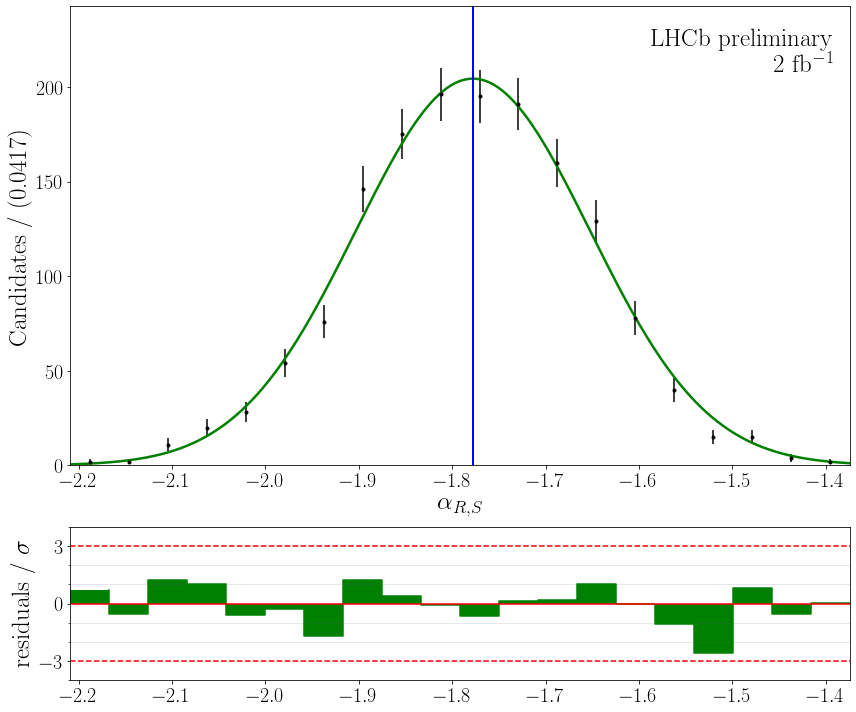

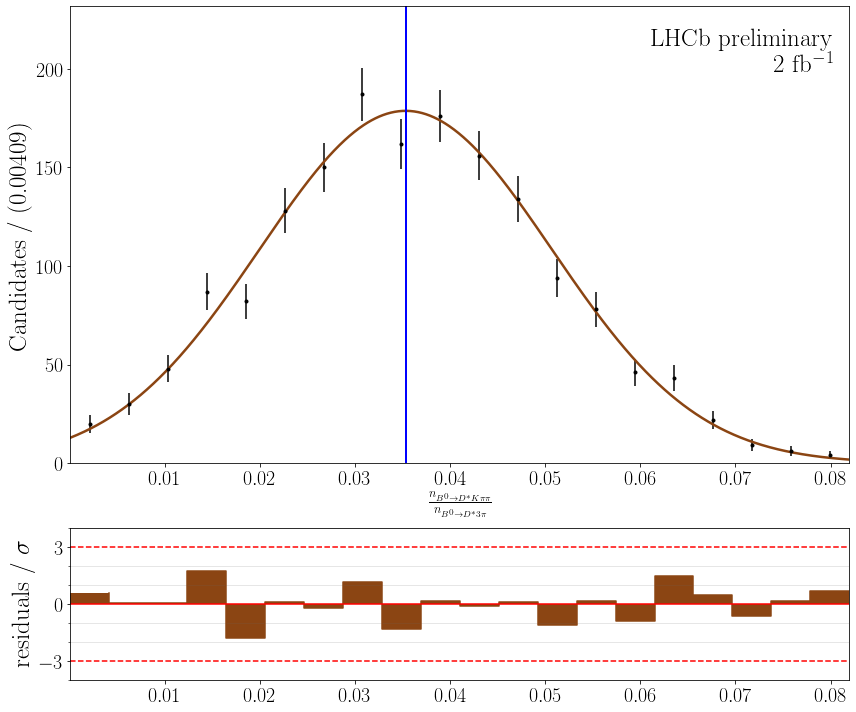

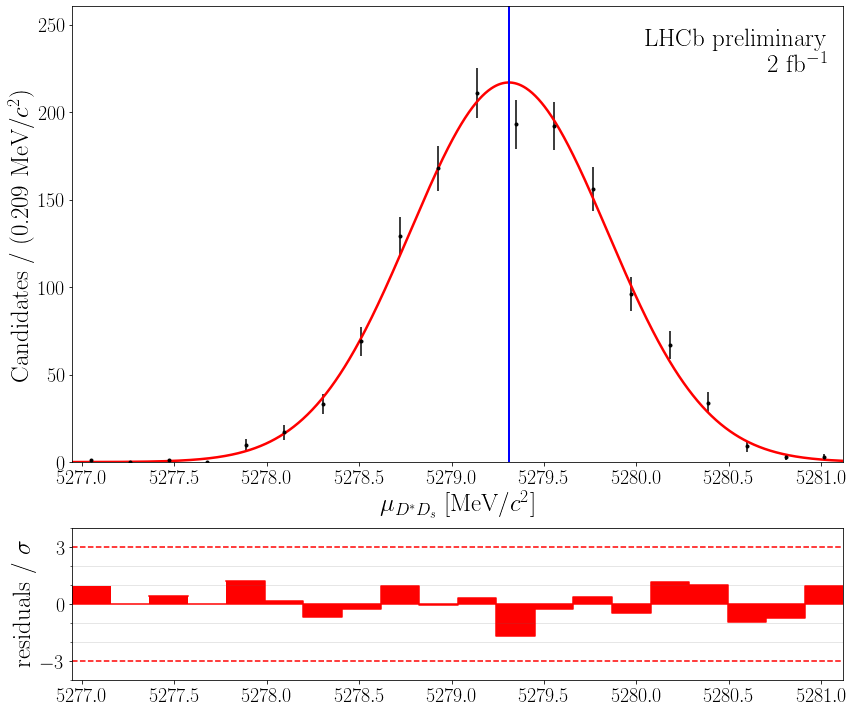

In [15]:

for m in modes:
    for name_param, data_param in parameters[m].items():

        type_data = params_mode[m][name_param]
        mean = saved_params[type_data][name_param]
        sigma = saved_params[type_data][name_param + '_err']

        initial_values = {
            f'mu_{name_param}'      :{ 'value': mean   , 'floating': True},
            f'sigma_{name_param}'   :{ 'value': sigma  , 'floating': True},
        }

        zparams = define_zparams(initial_values)

        obs = zfit.Space(name_param, limits=(min(data_param), max(data_param)))

        model = zfit.pdf.Gauss(zparams[f'mu_{name_param}'], zparams[f'sigma_{name_param}'], obs=obs)

        if 'mu' in name_param or 'sigma' in name_param:
            unit = 'MeV/$c^2$'
        else:
            unit=None        

        fig, ax, _ = plot_hist_fit_var(data_param, name_param,
                                       latex_params_dic[m][name_param],
                                       unit=unit,
                                       obs=obs, models = model,
                                       data_name = f'mode {m}',
                                       folder_name=f'{data_name}/parameters', n_bins=20, 
                                       bar_mode=False, colors=colors[m],
                                       pos_text_LHC='right', save_fig=False)

        #         fig, ax = plot_hist_var(data_param, name_param, branchiable = latex_params_dic[m][name_param],
        #                data_names = f'mode {m}',
        #               folder_name=f'{data_name}/parameters', n_bins=20, bar_mode=False, colors=colors[m],
        #                          pos_text_LHC='right', save_fig=False)
        file = params_mode[m][name_param]
        ax.axvline(x=saved_params[file][name_param], color='blue', linewidth=2.)
        save_fig(fig, fig_name =f'{name_param}_mode{m}', folder_name=f'{data_name}/parameters')

In [16]:
print(min(n_sig['1']), max(n_sig['1']))
print(min(n_sig['2']), max(n_sig['2']))

51015.22266714085 57093.48869214426
51158.358656833785 52997.02901239228


## COMPUTATION WITH `np.std`

### Standard deviation of mode 1 and mode 2

In [17]:
n_std = {m: np.std(n_sig[m]) for m in modes}

for m in modes:
    print(f"Uncertainty associated with the mode {m}: {n_std[m]}")
 

Uncertainty associated with the mode 1: 805.6719507088303
Uncertainty associated with the mode 2: 339.71129309995536
Uncertainty associated with the mode 3: 52.77090239122246


### Total standard deviation of the two modes, = systematic uncertainty

In [18]:
sigma_syst = sqrt(n_std['1']**2+n_std['2']**2+n_std['3']**2)

In [19]:
print("Total systematic uncertainty")
print(sigma_syst)

Total systematic uncertainty
875.9542356526393


### systematic uncertainty compared to the yield

In [20]:
sigma_syst/n_sig_opt

0.01674161888529375

### normalisation mode yield and statistical uncertainty

In [21]:
n_sig_opt

52321.955341015375

In [22]:
n_sig_opt_err

278.8860881796209

### total uncertainty (statistical + systematic)

In [23]:
sigma_tot = sqrt(sigma_syst**2+n_sig_opt_err**2)

In [24]:
sigma_tot

919.2786700114013

In [25]:
sigma_tot/n_sig_opt

0.01756965434529117

### Non optimal

In [26]:
n_sig_nonOpt = retrieve_params(f"{data_name_common}", folder_name=data_name_common)[f'n_sig']
n_sig_nonOpt_err = retrieve_params(f"{data_name_common}", folder_name=data_name_common)[f'n_sig_err']

In [27]:
n_sig_nonOpt_err/n_sig_nonOpt

0.02262394580343417

### optimal

In [28]:
n_sig_opt_err/n_sig_opt

0.0053301923898283875